<a href="https://colab.research.google.com/github/AyazNakhudaGitHub/BERT_Customer_Reviews_Classification/blob/main/Yelp_testing_3_categories_Summary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Yelp Data Testing, 3 Categories, Summary Review Texts**

In this notebook, we test the model which utilized the summary data that was grouped into 3 categories. The data used for testing is the Yelp dataset provided. The model has never seen this dataset before.

In [ ]:
!pip install -q tf-models-official==2.4.0

     |████████████████████████████████| 1.1 MB 8.4 MB/s 
     |████████████████████████████████| 1.1 MB 58.9 MB/s 
     |████████████████████████████████| 352 kB 93.9 MB/s 
     |████████████████████████████████| 213 kB 102.8 MB/s 
     |████████████████████████████████| 1.2 MB 60.0 MB/s 
     |████████████████████████████████| 596 kB 58.4 MB/s 
     |████████████████████████████████| 43 kB 2.4 MB/s 
     |████████████████████████████████| 99 kB 11.9 MB/s 
     |████████████████████████████████| 47.6 MB 1.1 MB/s 


In [ ]:
!pip install -q -U tensorflow-text

     |████████████████████████████████| 4.9 MB 9.1 MB/s 


In [ ]:
import os
import urllib, json

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import seaborn as sns
from tensorflow.keras.utils import to_categorical

import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization as tokenization

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1572224646813362459
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16154099712
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 2038829120124825658
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
 xla_global_id: 416903419]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
yelp_data = pd.read_pickle("small_yelp")

Below we select an equal number of instances from each category.

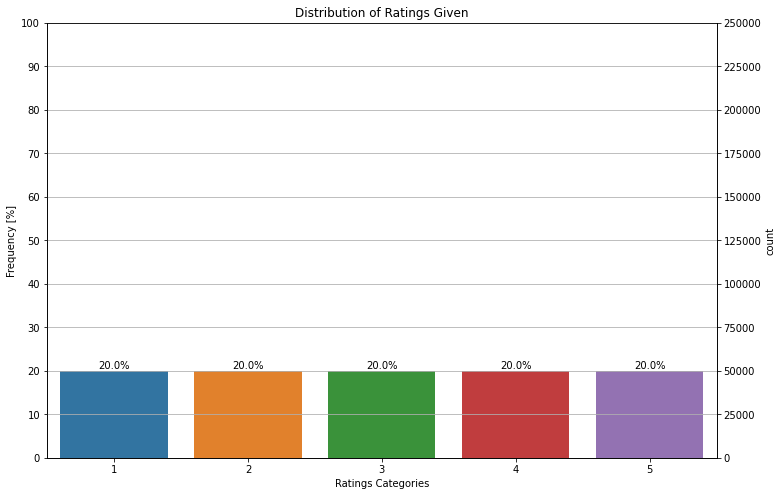

In [ ]:
import seaborn as sns
import matplotlib.ticker as ticker
plt.figure(figsize=(12,8))
ax = sns.countplot(x="stars", data=yelp_data, order=[1,2,3,4,5])
plt.title('Distribution of Ratings Given')
plt.xlabel('Ratings Categories')
ncount = len(yelp_data)
# Make twin axis
ax2=ax.twinx()

# Switch so count axis is on right, frequency on left
ax2.yaxis.tick_left()
ax.yaxis.tick_right()

# Also switch the labels over
ax.yaxis.set_label_position('right')
ax2.yaxis.set_label_position('left')

ax2.set_ylabel('Frequency [%]')

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y),
            ha='center', va='bottom') # set the alignment of the text

# Use a LinearLocator to ensure the correct number of ticks
ax.yaxis.set_major_locator(ticker.LinearLocator(11))

# Fix the frequency range to 0-100
ax2.set_ylim(0,100)
ax.set_ylim(0,ncount)

# And use a MultipleLocator to ensure a tick spacing of 10
ax2.yaxis.set_major_locator(ticker.MultipleLocator(10))

# Need to turn the grid on ax2 off, otherwise the gridlines end up on top of the bars
ax2.grid(None)

In [ ]:
yelp_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250000 entries, 550897 to 2950589
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   stars   250000 non-null  int64 
 1   text    250000 non-null  object
 2   useful  250000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 17.6+ MB


In [ ]:
yelp_data.head(30)

,stars,text,useful
550897,1,I went to this crummy den of rat turds on a bl...,1
515660,1,This body shop is the worst. I would never ta...,0
539261,1,I had one plate and left most of it on there. ...,3
2496804,1,I'm disappointed that I didn't go with lil Cae...,1
4248315,1,Forget the somewhat manufactured-looking decen...,3
3129230,1,Customer service is horrible. Did not know thi...,0
614763,1,Bof - le pizza average et les pâtes - plate du...,1
828025,1,I really was hoping this was a great restauran...,0
1750500,1,"Horrible, trash , bad reception ! Bad attitude...",0
172812,1,"my bad, i wasted my time and breath here AGAIN...",1


In [ ]:
from sklearn.utils import shuffle # shuffling the new data set
yelp_data = shuffle(yelp_data)
yelp_data.reset_index(inplace=True, drop=True)

In [ ]:
yelp_data.head(30)

,stars,text,useful
0,5,This place is outstanding. Their doughnuts are...,0
1,3,Overall 3.5 stars\n\nWe flew United into Las V...,3
2,4,Great place for pizza! I haven't actually been...,2
3,3,Nice spot. Great music. The jalapeños were goo...,0
4,1,"We arrived in Vegas 12\/21, I had called about...",4
5,3,I came here because a lot of people I know say...,0
6,4,(The stars are for the food and the funny peop...,0
7,2,"I actually feel bad even writing this, because...",5
8,2,I was extremely disappointed when I first visi...,2
9,3,TLDR: Just an OK stay for the price\n\nWe had ...,1


In [ ]:
# getting the 1's 
np.random.seed(10)
get_n = 25000
index_to_get = yelp_data[yelp_data.stars == 1].index
get_indices_a = np.random.choice(index_to_get, get_n, replace=False)
data_a = yelp_data.loc[get_indices_a]

# getting the 2's 
np.random.seed(10)
get_n = 25000
index_to_get = yelp_data[yelp_data.stars == 2].index
get_indices_b = np.random.choice(index_to_get, get_n, replace=False)
data_b = yelp_data.loc[get_indices_b]


# getting the 3's
np.random.seed(10)
get_n = 50000
index_to_get = yelp_data[yelp_data.stars == 3].index
get_indices_c = np.random.choice(index_to_get, get_n, replace=False)
data_c = yelp_data.loc[get_indices_c]

# getting the 4's
np.random.seed(10)
get_n = 25000
index_to_get = yelp_data[yelp_data.stars == 4].index
get_indices_d = np.random.choice(index_to_get, get_n, replace=False)
data_d = yelp_data.loc[get_indices_d]

# getting the 5's
np.random.seed(10)
get_n = 25000
index_to_get = yelp_data[yelp_data.stars == 5].index
get_indices_e = np.random.choice(index_to_get, get_n, replace=False)
data_e = yelp_data.loc[get_indices_e]


In [ ]:
drop_indicies = np.concatenate((get_indices_a,get_indices_b,get_indices_c,get_indices_d,get_indices_e),axis=0)
yelp_data_new = pd.concat([data_a, data_b, data_c,data_d,data_e])

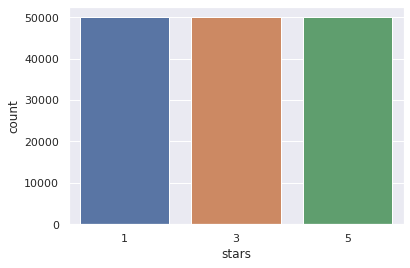

In [ ]:
for index, row in yelp_data_new.iterrows():
    if row['stars'] == 2:
      yelp_data_new.at[index,'stars'] = 1
    elif row['stars'] == 4:
      yelp_data_new.at[index,'stars'] = 5

sns.set_theme()
ax = sns.countplot(x="stars", data=yelp_data_new)

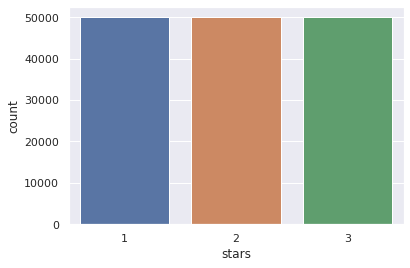

In [ ]:
for index, row in yelp_data_new.iterrows():
    if row['stars'] == 3:
       yelp_data_new.at[index,'stars'] = 2
    elif row['stars'] == 5:
      yelp_data_new.at[index,'stars'] = 3

sns.set_theme()
ax = sns.countplot(x="stars", data=yelp_data_new)

In [ ]:
from sklearn.utils import shuffle # shuffling the new data set
yelp_data_new = shuffle(yelp_data_new)
yelp_data_new.reset_index(inplace=True, drop=True)

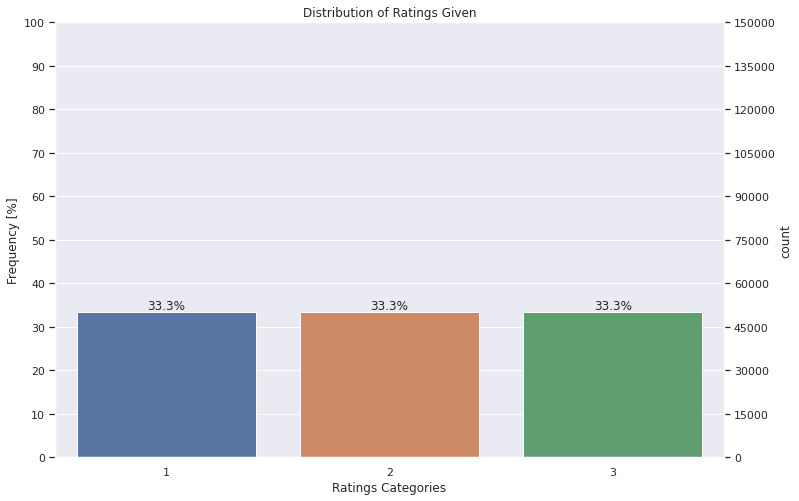

In [ ]:
import matplotlib.ticker as ticker
plt.figure(figsize=(12,8))
ax = sns.countplot(x="stars", data=yelp_data_new, order=[1,2,3])
plt.title('Distribution of Ratings Given')
plt.xlabel('Ratings Categories')
ncount = len(yelp_data_new)
# Make twin axis
ax2=ax.twinx()

# Switch so count axis is on right, frequency on left
ax2.yaxis.tick_left()
ax.yaxis.tick_right()

# Also switch the labels over
ax.yaxis.set_label_position('right')
ax2.yaxis.set_label_position('left')

ax2.set_ylabel('Frequency [%]')

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text

# Use a LinearLocator to ensure the correct number of ticks
ax.yaxis.set_major_locator(ticker.LinearLocator(11))

# Fix the frequency range to 0-100
ax2.set_ylim(0,100)
ax.set_ylim(0,ncount)

# And use a MultipleLocator to ensure a tick spacing of 10
ax2.yaxis.set_major_locator(ticker.MultipleLocator(10))

# Need to turn the grid on ax2 off, otherwise the gridlines end up on top of the bars
ax2.grid(None)

In [ ]:
bert_layer=hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2",trainable=True)

In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])

[101, 102]

In [ ]:
x = yelp_data_new.text.values
y = yelp_data_new.stars.values

encoder = LabelEncoder()
encoder.fit(y)

encoded_Y_test = encoder.transform(y)
dummy_y_test = to_categorical(encoded_Y_test)

In [ ]:
max_seq_length = 85


In [ ]:
def encode_names(n, tokenizer):
   #tokens = list(tokenizer.tokenize(n))
   tokens = list(tokenizer.tokenize(n)[:24]+tokenizer.tokenize(n)[-59:])
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(string_list, tokenizer, max_seq_length):
  num_examples = len(string_list)
  
  string_tokens = tf.ragged.constant([
      encode_names(n, tokenizer) for n in np.array(string_list)])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*string_tokens.shape[0]
  input_word_ids = tf.concat([cls, string_tokens], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor(shape=(None, max_seq_length))

  type_cls = tf.zeros_like(cls)
  type_tokens = tf.ones_like(string_tokens)
  input_type_ids = tf.concat(
      [type_cls, type_tokens], axis=-1).to_tensor(shape=(None, max_seq_length))



  inputs = {
      'input_word_ids': input_word_ids.to_tensor(shape=(None, max_seq_length)),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

In [ ]:
X_test = bert_encode(x, tokenizer, max_seq_length)

In [ ]:
# load in the model which achieved 67.59% testing accuracy using 3 categories instead of 5 and also used the summarized text for training.
model_fname = 'Ratings_BERT_Summary_3cat_run2'
my_wd = '/content/drive/My Drive'

model = tf.keras.models.load_model(os.path.join(my_wd, model_fname)) 

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test, batch_size=8, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1) + 1
print(classification_report(y, y_pred_bool, labels=[1,2,3], digits=4))
loss, accuracy = model.evaluate(X_test, dummy_y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

18750/18750 [==============================] - 612s 33ms/step
              precision    recall  f1-score   support

           1     0.6267    0.8794    0.7319     50000
           2     0.7069    0.2363    0.3542     50000
           3     0.6755    0.8528    0.7539     50000

    accuracy                         0.6562    150000
   macro avg     0.6697    0.6562    0.6133    150000
weighted avg     0.6697    0.6562    0.6133    150000

Testing Accuracy:  0.6562
